In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
def compute_rcm(n_cluster,centroids):
    #since all the particles have the same mass, the center of mass is  just the arithmetic average weighted by the number of particles in each cluster 
    numerator = 0
    n_tot = 0
    for i in np.arange(n_cluster):
        N = len(np.where(labels==i)[0]) #number of particles in each cluster
#         print "n_clusters:", i 
#         print "nuumber of particles in each cluster ", N
#         print "cluster center" , centroids[i]    
        numerator += centroids[i]*N 
#         print "numerator: " , numerator
        n_tot+=N
    rcm = numerator/n_tot
    return rcm

In [4]:
def compute_avrg_rad(n_cluster,centroids):
    numerator = 0
    n_tot = 0
    for i in np.arange(n_cluster):
        numerator += np.linalg.norm(centroids[i]-compute_rcm(n_cluster,centroids))
    return numerator/n_cluster

So it looks like average radius doesn't encircle all the datapoint but that's okay because we are jsut computing a average density 

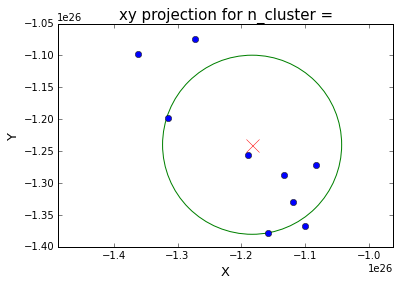

In [19]:
def verify_cm_calculation(n_cluster,centroids):
    fig  = plt.figure()
    plt.title("xy projection for n_cluster = ".format(n_cluster),fontsize=15)
    plt.plot(centers[:,0], centers[:,1],'o')
    rcm = compute_rcm(n_cluster,centroids)
    plt.plot(rcm[0],rcm[1],"x", color = "red", markersize=13)
    rad = compute_avrg_rad(n_cluster,centroids)
    circle1 = plt.Circle((rcm[0],rcm[1]),rad,color='g',fill=False)
    fig.gca().add_artist(circle1)
    plt.xlabel("X",fontsize=13)
    plt.ylabel("Y",fontsize=13)
    axes().set_aspect('equal', 'datalim')
verify_cm_calculation(8,centers)

In [20]:
rad = compute_avrg_rad(8,centers)
volume = (4./3.*pi*rad**3)
mass = 2.75491975e43 * len(labels)
density = mass / volume
print density

9.47919788403e-31


Don't worry about the division by zero error that just comes from the fact that R=0 for the n_cluster=1 case so then when computing the density the volume is zero so then it complains. Density of a point particle is undefined anyways, or rather infinity...

Loading Particle Data

Creating train test split samples

training set size : 
(399, 5)
testing  set size : 
(100, 5)


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars


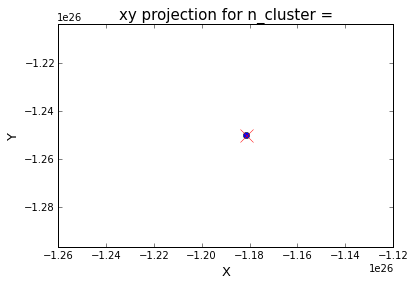

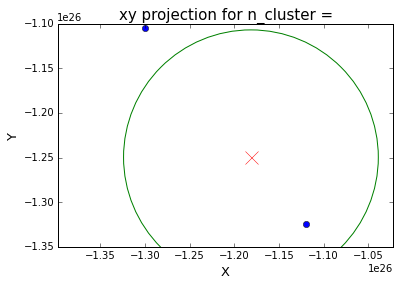

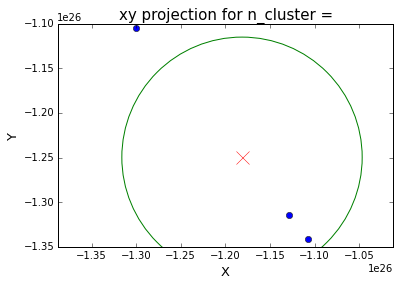

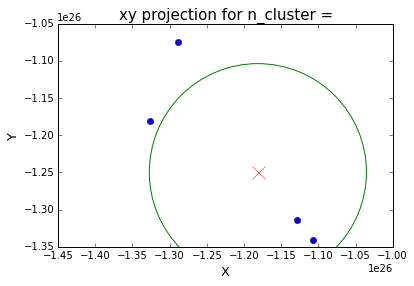

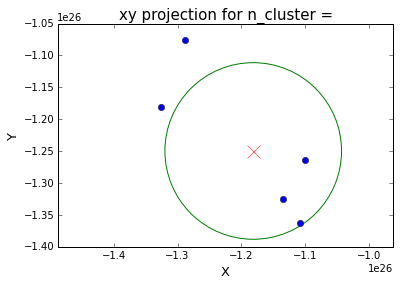

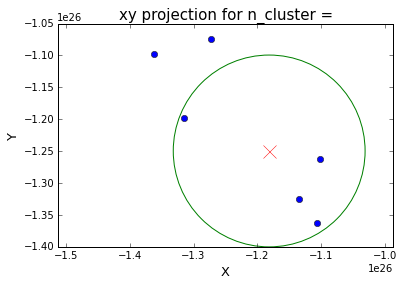

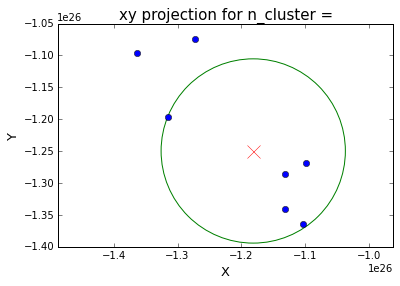

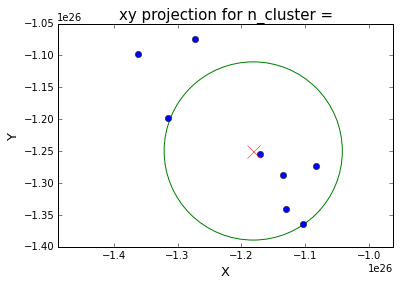

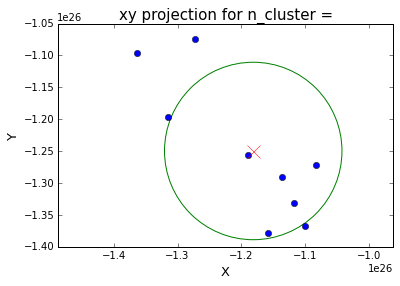

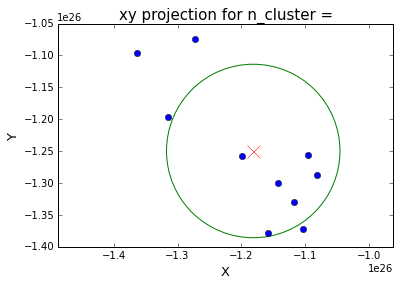

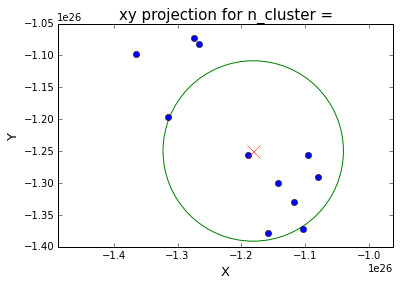

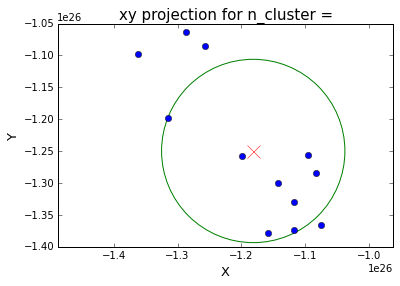

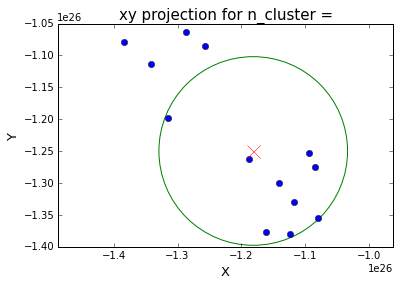

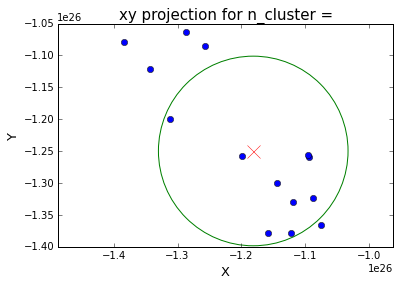

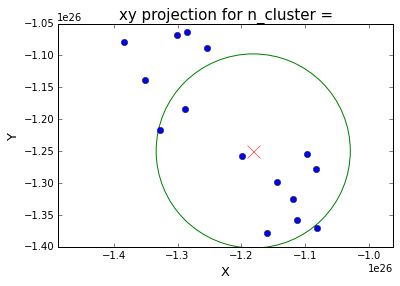

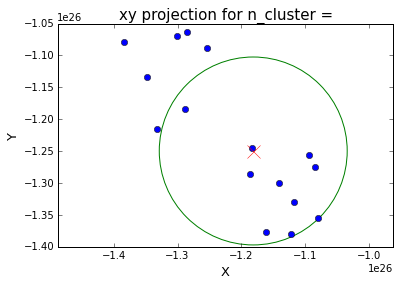

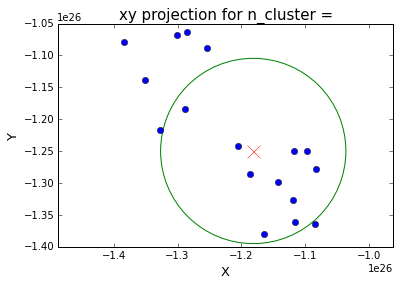

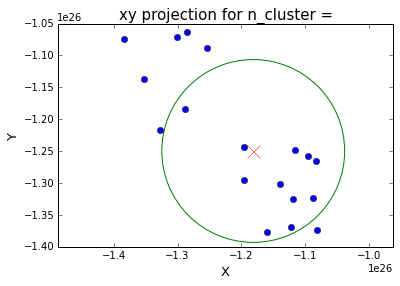

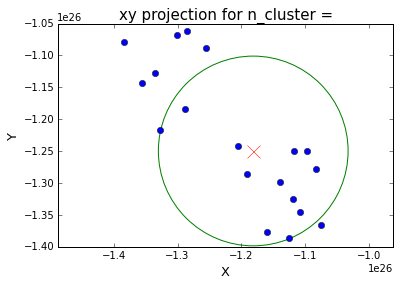

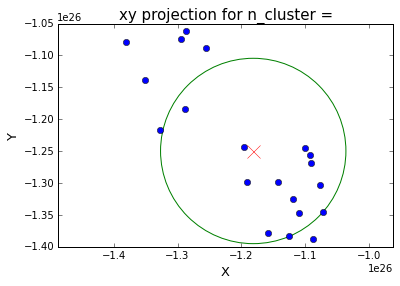

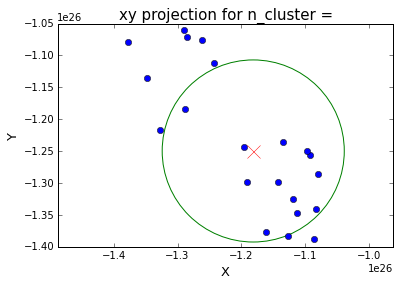

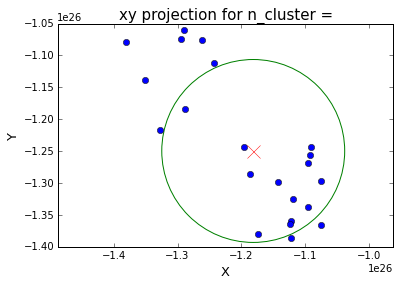

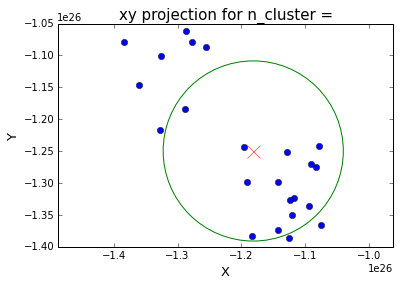

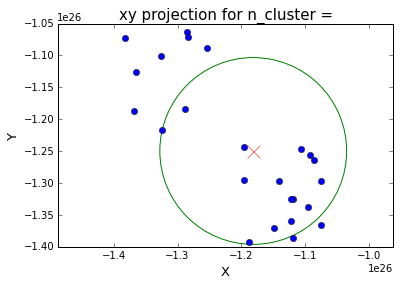

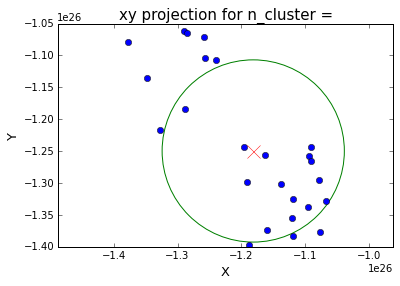

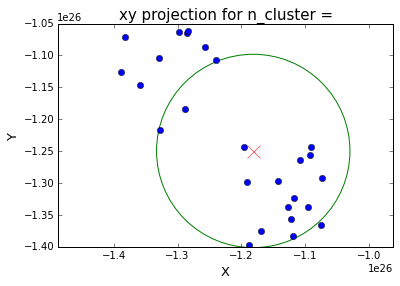

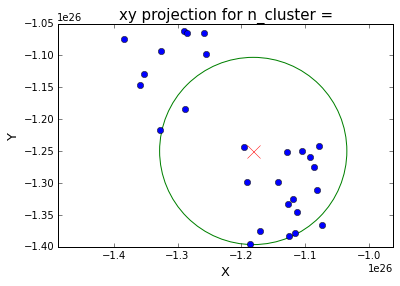

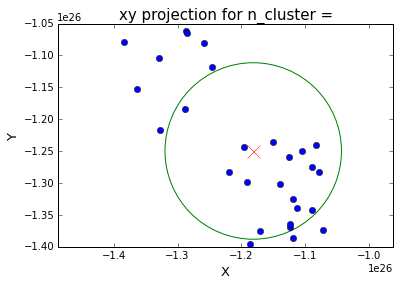

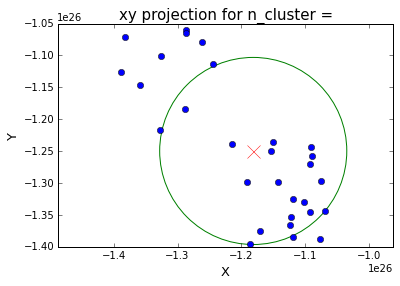

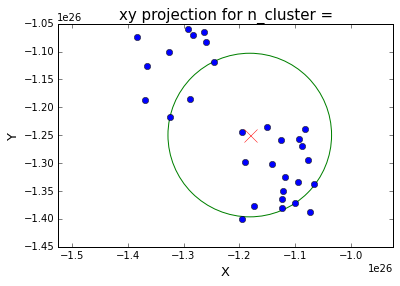

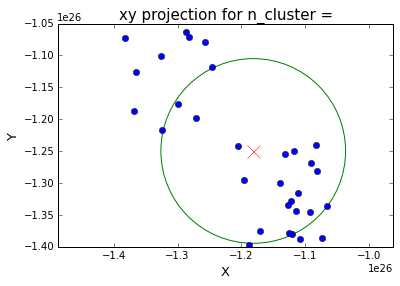

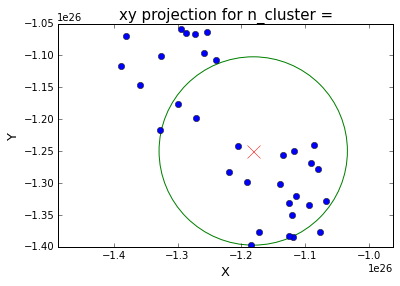

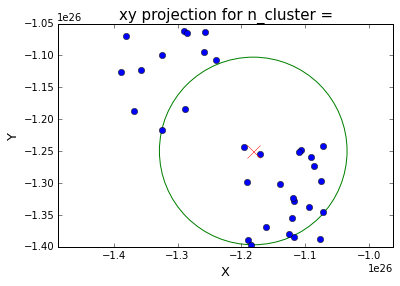

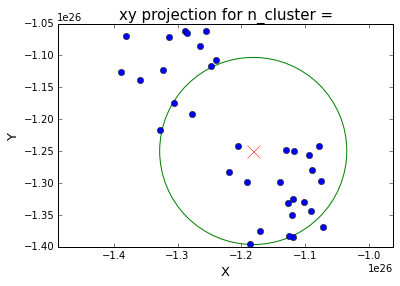

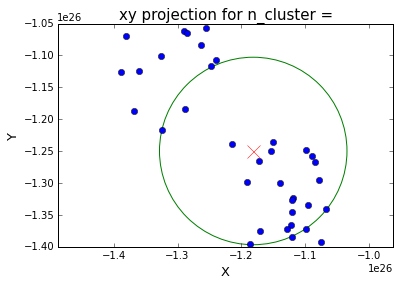

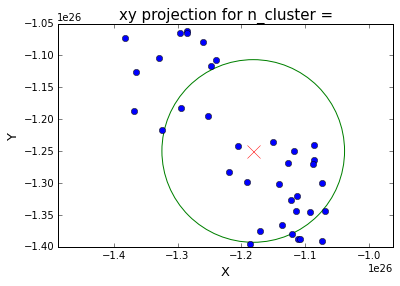

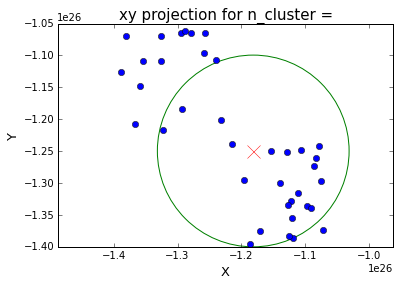

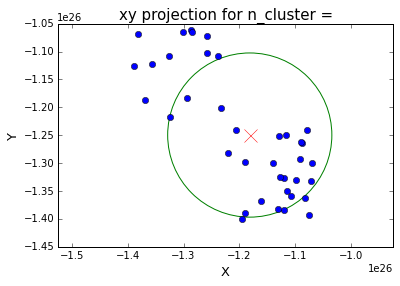

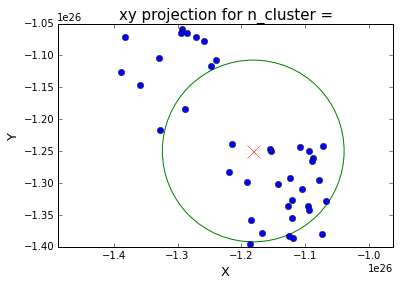

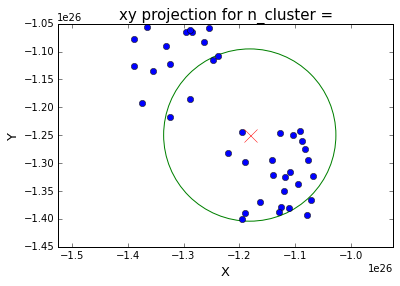

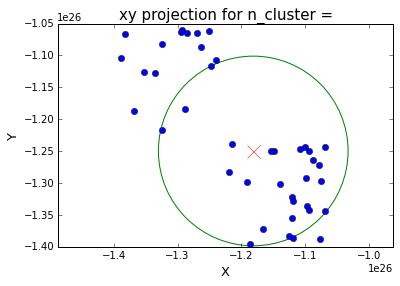

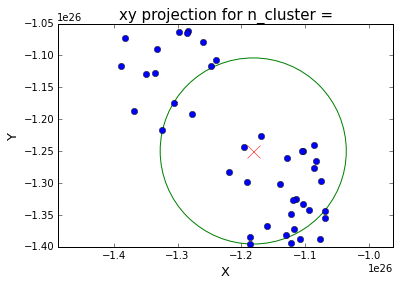

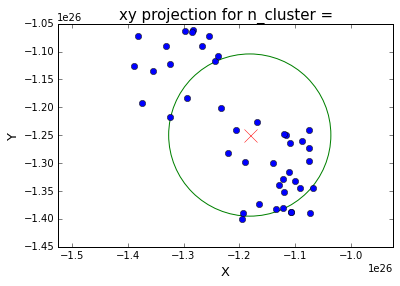

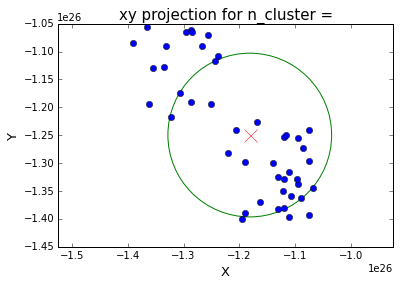

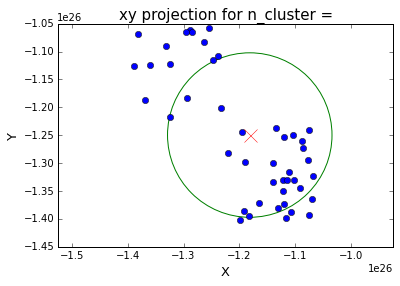

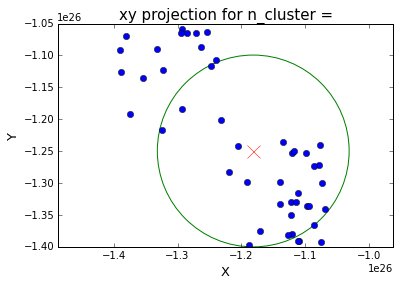

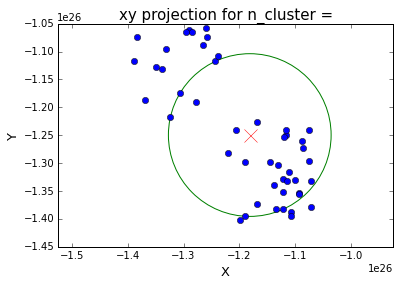

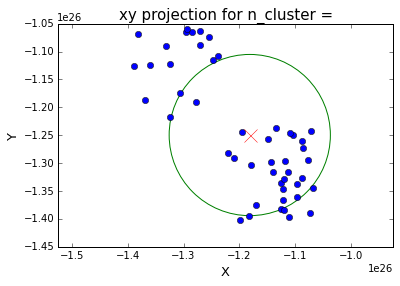

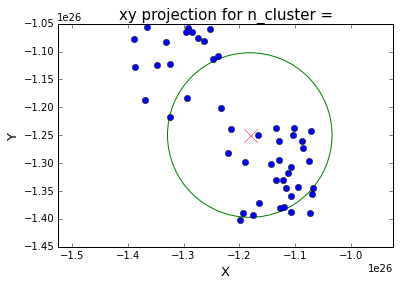

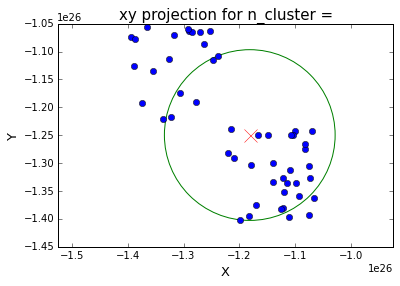

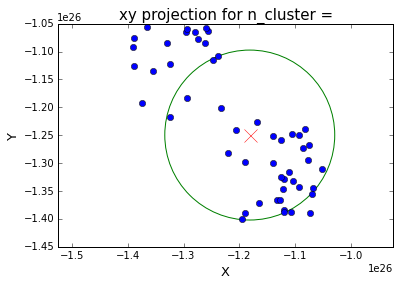

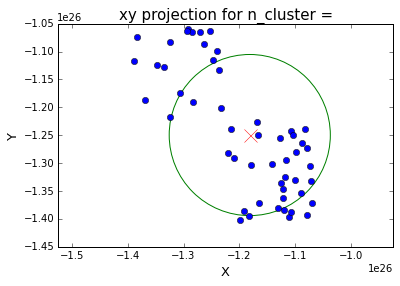

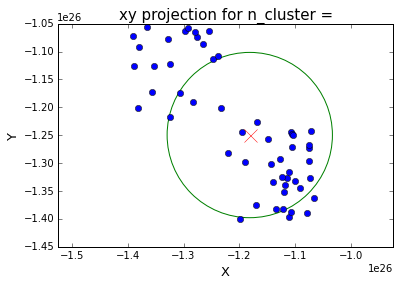

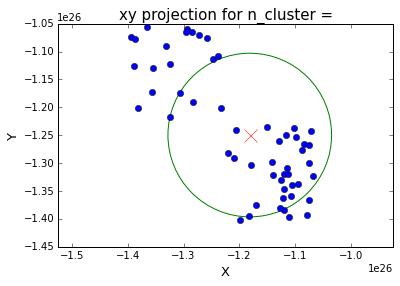

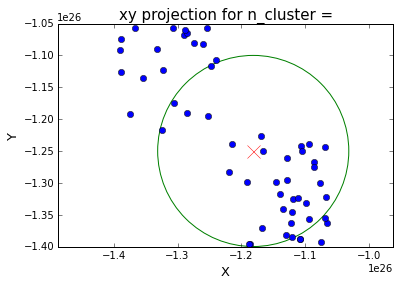

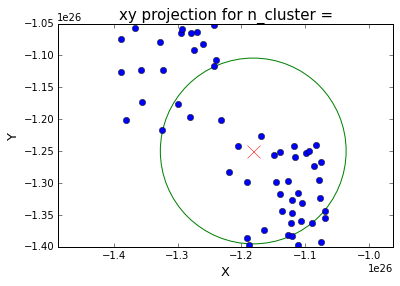

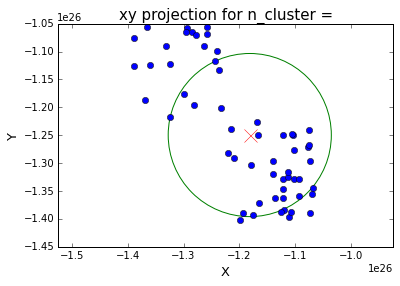

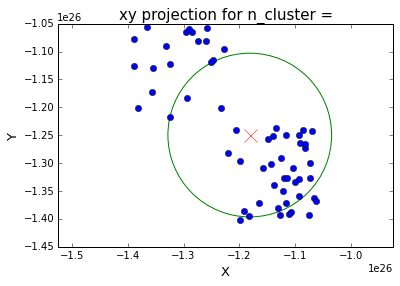

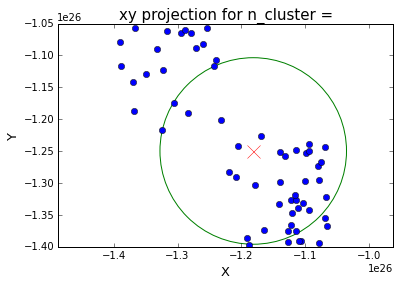

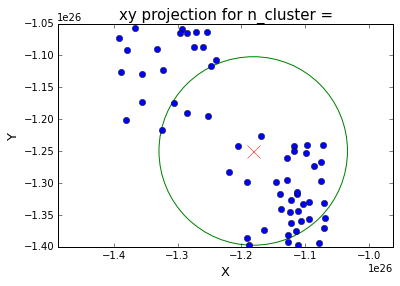

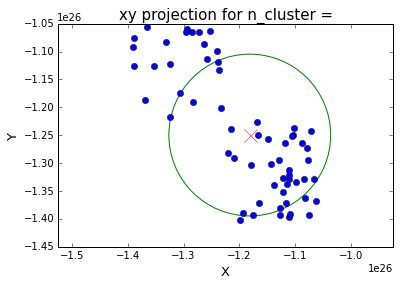

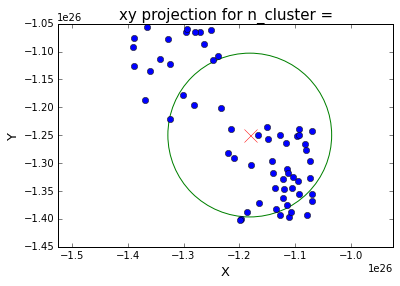

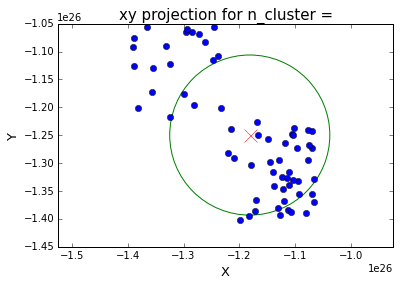

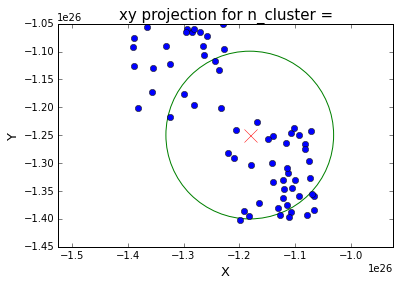

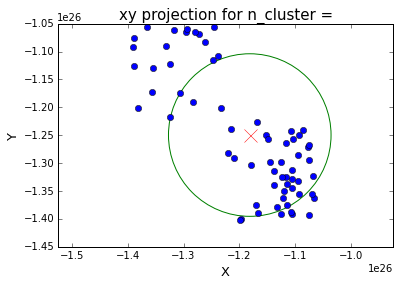

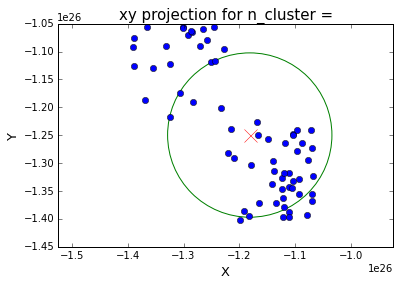

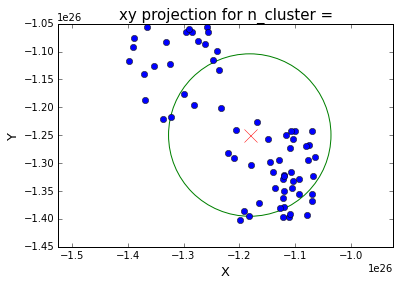

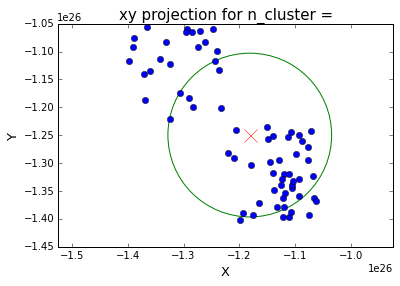

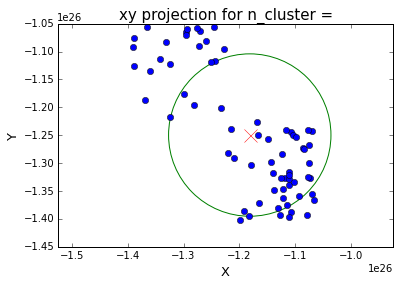

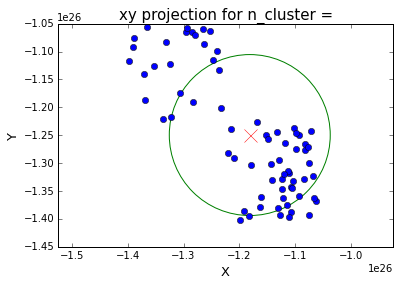

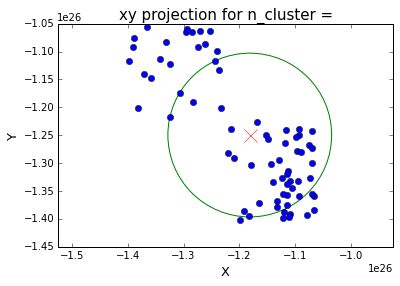

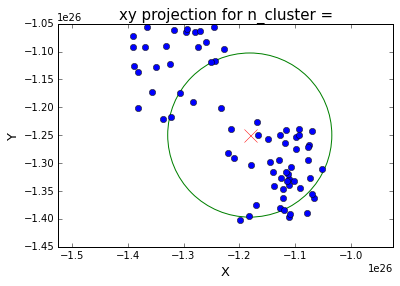

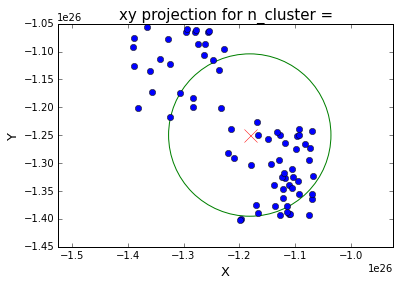

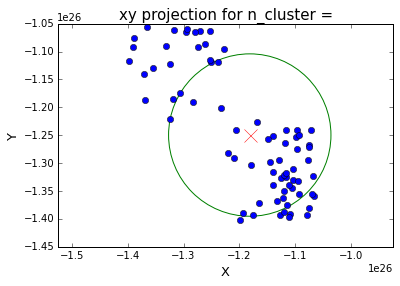

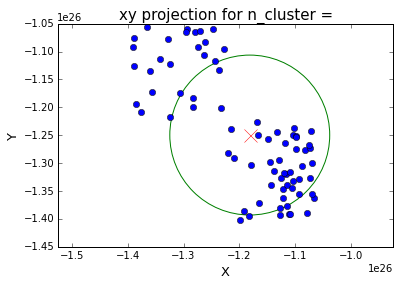

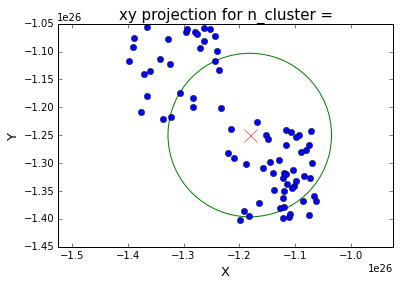

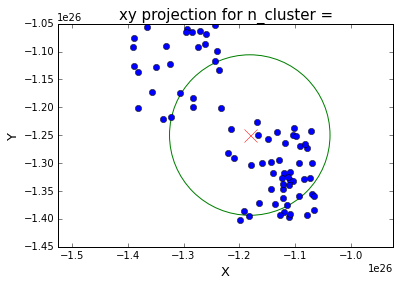

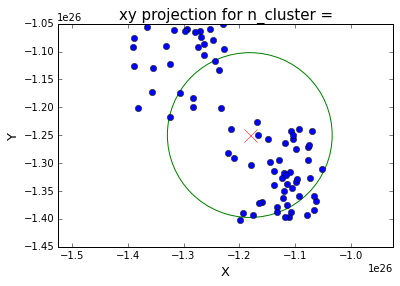

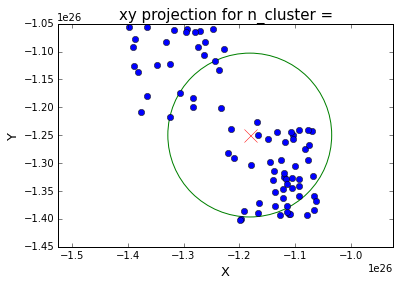

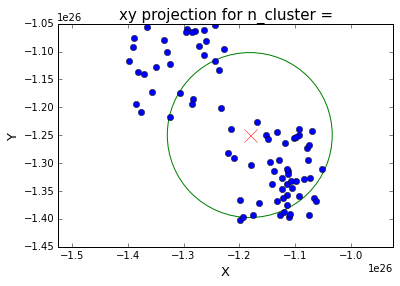

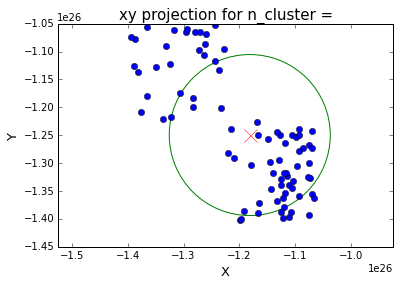

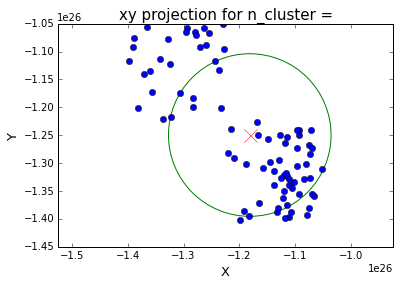

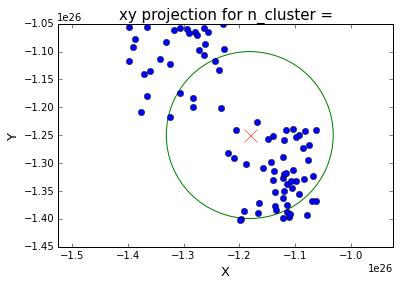

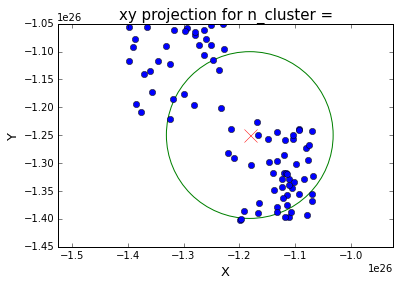

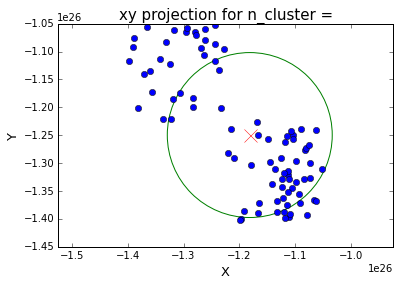

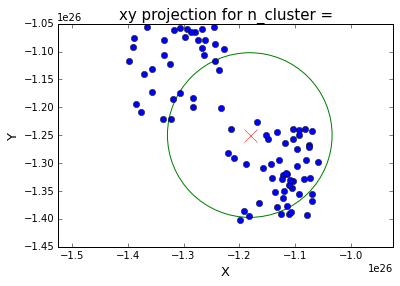

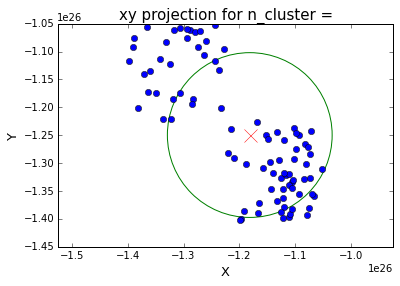

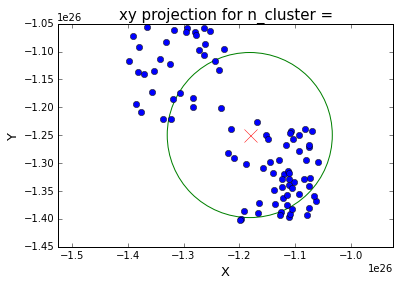

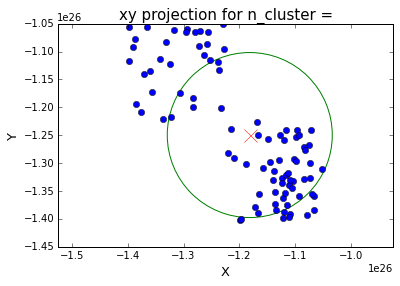

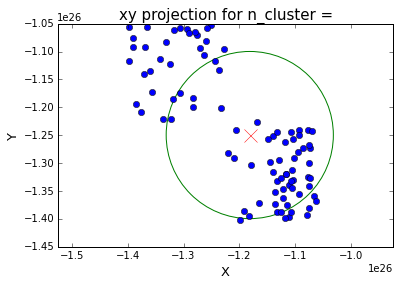

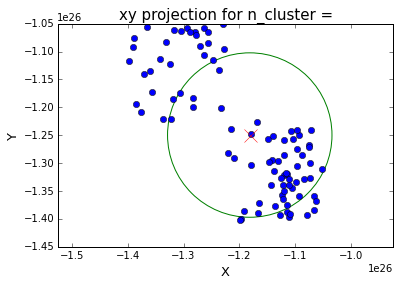

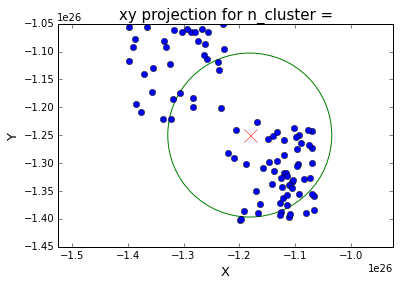

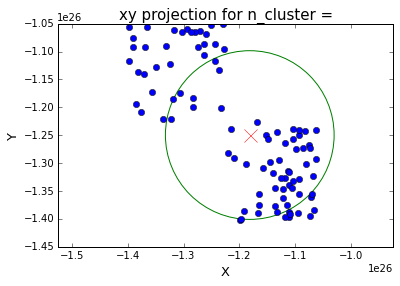

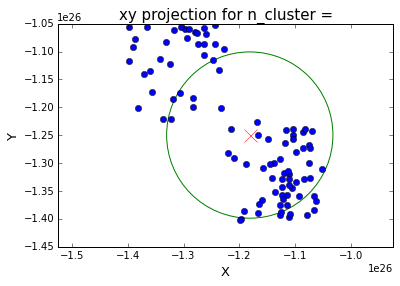

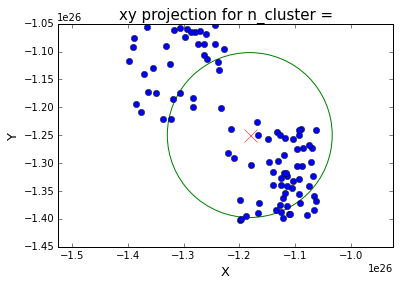

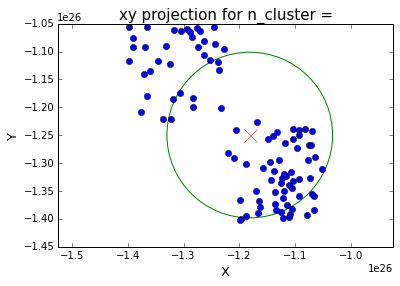

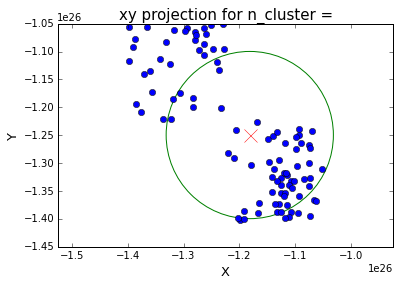

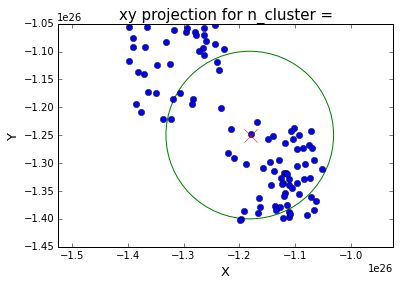

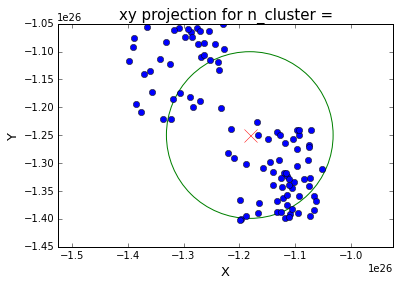

In [23]:
import numpy as np
import yt
import sklearn
yt.funcs.mylog.setLevel(50)
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cross_validation import cross_val_score
from sklearn.cluster import KMeans
from sklearn.grid_search import GridSearchCV
DEBUG= True
def debug(s,n=""):
    if DEBUG:
        print s
        print n
debug("Loading Particle Data")
ds = yt.load("../ds14_scivis_0128_e4_dt04_1.0000")
ad = ds.all_data()
x = ad[("all","particle_position_x")]
y = ad[("all","particle_position_y")]
z = ad[("all","particle_position_z")]
debug("Creating train test split samples")
m = ad[("all","mass")]
idx = ad[("all","particle_index")]
train = []
test = []
N = 500
N_split = 100
for n in np.arange(N):
    if n >N_split:
        train.append([idx[n],m[n].in_cgs(),x[n].in_cgs(),y[n].in_cgs(),z[n].in_cgs()])
#         train.append([x[n].in_cgs(),y[n].in_cgs(),z[n].in_cgs()])
    elif n<N_split:
        test.append([idx[n],m[n].in_cgs(),x[n].in_cgs(),y[n].in_cgs(),z[n].in_cgs()])
#         test.append([x[n].in_cgs(),y[n].in_cgs(),z[n].in_cgs()])
train = np.array(train)
test = np.array(test)
debug("training set size : ", np.shape(train))
debug("testing  set size : ", np.shape(test))
# Explicit Grid Search 
k_range = range(1, 100)
# k_scores = []
densities =[]
for k in k_range:
    clf = KMeans(n_clusters=k)
    clf.fit(train[:,2:])#ignoring idx and mass 
    centers=clf.cluster_centers_
    labels = clf.labels_
    rad = compute_avrg_rad(k,centers)
    volume = (4./3.*pi*rad**3)
    mass = 2.75491975e43 * len(labels)
    density = mass / volume
#     print density
    verify_cm_calculation(k,centers)
    densities.append(density)
#     print k,"clusters"
#     print centers
#     print labels

This is interesting because it looks like the higher K values has its own clustering behavior so the high K gives us degenerate models 

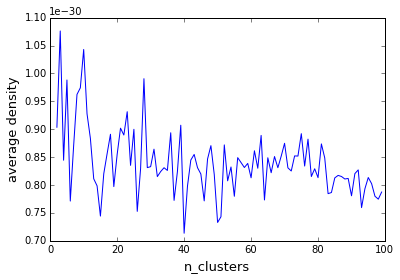

In [28]:
plt.plot(k_range,np.array(densities))
plt.xlabel("n_clusters",fontsize=13)
plt.ylabel("average density",fontsize=13)

Okay need to run this on more particles to get an accurate measure 